# Multiple objective land allocation (MOLA)

This notebook present an example of a MOLA analysis using python. We set up the problem as a linear programming optimization problem and solve it. This example is based on material from Sam Ratick at Clark University.

In [42]:
############### SESYNC Research Support: Urban green planning ########## 
## Testing optimization.
## 
##
## DATE CREATED: 11/15/2018
## DATE MODIFIED: 12/07/2018
## AUTHORS: Benoit Parmentier  
## Version: 1
## PROJECT: Urban green infrastructure planning
## ISSUE: 
## TO DO:
##
## COMMIT: fixed gdal.Warp bug, reprojection to MD SRS
##

###################################################
#

###### Library used

import gdal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import scipy
from math import cos
import cvxpy

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script 
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

############################################################################
#####  Parameters and argument set up ########### 

#ARGS 1
in_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/Data"
#in_dir <- "/nfs/tjovanovic-data/Data/Baltimore/Hydrology/GAstart"
#ARGS 2
out_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/outputs"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 7
out_suffix = "mola_example_12032018" #output suffix for the files and ouptut folder
#ARGS 8
num_cores = 2 # number of cores
file_format = ".tif"

#dem_baltimore_filename = "DEM_BaltArea_1m.tif"
#lc_baltimore_filename = "landCover_area1m.tif"
#reg_outline_filename = "watersheds8digit.shp"

################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    #out_path<-"/data/project/layers/commons/data_workflow/output_data"
    out_dir = "output_data_"+out_suffix
    out_dir = os.path.join(in_dir,out_dir)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier

directory already exists


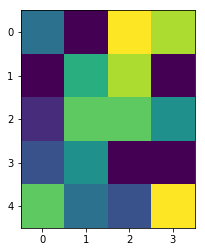

In [43]:
#######################################
### PART 1: Read in DATA #######

# Let's create a factor (attribute) in the multiobjective land allocation:

r_d = np.arange(25).reshape((5, 5))         # create a 1-d range and reshape
plt.imshow (r_d)

f2 = [3,0,8,7,
     0,5,7,0,
     1,6,6,4,
    2,4,0,0,
    6,3,2,8]
f2 = np.asarray(f2)

r_d = f2.reshape((5,4))         # distance to road
plt.imshow (r_d)



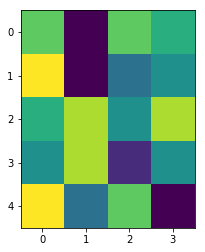

In [44]:
### Now generate second factor: Map slope

f2 = [6,0,6,5,
     8,0,3,4,
     5,7,4,7,
     4,7,1,4,
     8,3,6,0]
f2 = np.asarray(f2)

r_s = f2.reshape((5,4))         # slope map
plt.imshow (r_s)


#### Problem set up

Assume that you are land planner and you are tasked with selecting areas for the development of as ski resort whil setting aside land for Habitat protection. The steps are as follow:

1. Create factor maps (variables/criteria) relevant for your land use type objective.
2. Select, obtain or generate weights to combine your factor (e.g. AHP, SMART etc.)
3. Generate a suitability map for your land objective that combines all factors



[[15  0 30 26]
 [ 8 15 24  4]
 [ 8 25 22 19]
 [10 19  1  4]
 [26 12 12 24]]


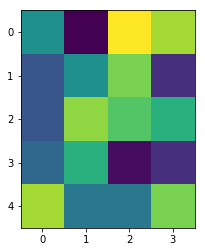

In [47]:
# Generate Habitat suitability 

r_suitability_habitat = 3*r_d + 1 * r_s 
print(r_suitability_habitat)
plt.imshow (r_suitability_habitat)
# note cell [1,1] is 15= 3*3 + 1*6

[[15  0 20 17]
 [16  5 13  8]
 [11 20 14 18]
 [10 18  2  8]
 [22  9 14  8]]


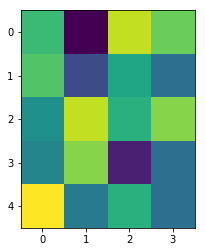

In [48]:
# Generate Ski resort suitability 

r_suitability_ski = 1*r_d +2*r_s 
#r_suitability_ski = np.add(1*r_d,2*r_s)

print(r_suitability_ski)
plt.imshow(r_suitability_ski)
# note cell [1,1] is 17= 1*5 + 2*6

[[17  8 12 11]
 [24  3  7 16]
 [17 16 10 18]
 [14 18 10 16]
 [18 11 18  0]]


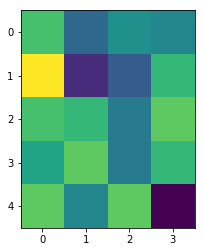

In [49]:
# Generate Ski resort suitability 

f1_ski = [5,8,0,1,
          8,3,1,8,
          7,2,2,4,
          6,4,8,8,
          2,5,6,0]

f2_ski = [6,0,6,5,
          8,0,3,4,
          5,7,4,7,
          4,7,1,4,
          8,3,6,0]

f1_ski = np.asarray(f1_ski)
f2_ski = np.asarray(f2_ski)

r_ski_s = f2_ski.reshape((5,4))         # slope map
plt.imshow (r_ski_s)
r_ski_d = f1_ski.reshape((5,4))         # distance map
plt.imshow (r_ski_d)

r_suitability_ski = 1*r_ski_d +2*r_ski_s 
#r_suitability_ski = np.add(1*r_d,2*r_s)

print(r_suitability_ski)
plt.imshow(r_suitability_ski)
# note cell [1,1] is 17= 1*5 + 2*6



In [50]:
# Set up linear problem for the land allocation

# Maximize 

# The data for the Knapsack problem
# P is total weight capacity of sack
# weights and utilities are also specified
P = 165 #Demand
weights = np.array([23, 31, 29, 44, 53, 38, 63, 85, 89, 82])
utilities = np.array([92, 57, 49, 68, 60, 43, 67, 84, 87, 72]) # suitability?

# The variable we are solving for
#selection = cvxpy.Bool(len(weights))#does not work
selection = cvxpy.Variable(len(weights), boolean=True)


# The sum of the weights should be less than or equal to P
weight_constraint = weights * selection <= P

# Our total utility is the sum of the item utilities
total_utility = utilities * selection #objective function

# We tell cvxpy that we want to maximize total utility 
# subject to weight_constraint. All constraints in 
# cvxpy must be passed as a list
knapsack_problem = cvxpy.Problem(cvxpy.Maximize(total_utility), [weight_constraint])

test=knapsack_problem.solve()
# Solving the problem
knapsack_problem.solve(solver=cvxpy.GLPK_MI)
cvxpy.
#print(test)
#type(test)


SyntaxError: invalid syntax (<ipython-input-50-cf583c47157a>, line 31)

In [18]:
## testing pulp package

from pulp import *
import numpy as np

items=['item_%d'%i for i in range(20)] # for spatial alocations,parcels or pixels to select 
item_weights = dict( (i,np.random.randint(1,20)) for i in items)
item_values = dict( (i,10*np.random.rand()) for i in items)
W = 100

#variables. How many of each object to take. For simplicity lets make this 0 or 1 (classic 0-1 knapsack problem)
x = LpVariable.dicts('item',items,0,1, LpBinary)

#create the problme
prob=LpProblem("knapsack",LpMaximize)

#the objective
cost = lpSum([ item_values[i]*x[i] for i in items])
prob+=cost

#constraint
prob += lpSum([ item_weights[i]*x[i] for i in items]) <= W

%time prob.solve()
print(LpStatus[prob.status])

for i in items:
    print(i, value(x[i]))

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 20.8 ms
Optimal
item_0 1.0
item_1 1.0
item_2 1.0
item_3 1.0
item_4 1.0
item_5 1.0
item_6 0.0
item_7 1.0
item_8 0.0
item_9 1.0
item_10 0.0
item_11 0.0
item_12 0.0
item_13 0.0
item_14 1.0
item_15 0.0
item_16 1.0
item_17 1.0
item_18 1.0
item_19 0.0


In [ ]:
from pulp import *
prob = LpProblem("Knapsack problem", LpMaximize)
cost = [15,18,18,23,18,20,15,16,12,12,25,25,28,35,28,28,25,25,25,28,25,32,32,28,25]
x = LpVariable.dicts('x',range(1,26),lowBound=0,upBound=12,cat=pulp.LpInteger)
cap = [150,180,180,230,180,200,150,160,120,120,250,250,280,350,280,280,250,250,250,280,250,320,320,280,250] 
prob += pulp.lpSum([cost[ix]*x[ix] for ix in range(1,25)]), "obj"
prob += pulp.lpSum([cap[ix]*x[ix] for ix in range(1,25)]) == 6600, "c1"
prob.solve()

print "Status:", LpStatus[prob.status]

for v in prob.variables():
    if v.varValue>0.0001:
        print v.name, "=", v.varValue

print ("objective = %s" % value(prob.objective))


In [127]:
## testing pulp package: Setting up the problem

from pulp import *
import numpy as np

number_of_objectives = 2
number_of_locations = 20
#n_pix = number_of_objectives*number_of_locations
n_pix = 20

pixels=['pixel_%d'%i for i in range(n_pix)] # for spatial application: locations,parcels or pixels to select 
#variables. How many of each object to take. For simplicity lets make this 0 or 1 (classic 0-1 knapsack problem)
x1 = LpVariable.dicts('pixel',pixels,0,1, LpBinary) #decision var for ski objective
x2 = LpVariable.dicts('pixel',pixels,0,1, LpBinary) #decision for habitat objection

val1 = dict(zip(pixels,r_suitability_ski.ravel().T))
val2 = dict(zip(pixels,r_suitability_habitat.ravel().T))
            
D = 10 #select 10 locations/pixels for ski, correspond to Weight in Knapsack 0-1


#create the problme
prob=LpProblem("knapsack",LpMaximize)

#the objective
#cost = lpSum([ item_values[i]*x[i] for i in items])
#list_obj2= [ val1[i]*x2[i] for i in pixels]

list_obj1= [ val1[i]*x1[i] for i in pixels]
list_obj2= [ val2[i]*x2[i] for i in pixels]

#cost1 = lpSum([ val1[i]*x1[i] for i in pixels]) # suitability sum ojb1
#cost2 = lpSum([ val2[i]*x2[i] for i in pixels]) # suitability sum ojb2

cost = lpSum(list_obj1 + list_obj2)
#prob+=cost
#prob+=cost1
#prob+=cost2
prob+=cost

#Demand constraint
#pixel_weights = np.ones(20)
pixel_weights = dict(zip(pixels,np.ones(20).T))
#val1 = dict(zip(pixels,r_suitability_ski.ravel().T))

#list_constraint1 = [pixel_weights[i]*x1[i] for i in pixels]
#list_constraint2 = [pixel_weights[i]*x2[i] for i in pixels]

#list_constraint1 + list_constraint2

list_constraint = [pixel_weights[i]*x1[i] for i in pixels]
prob += lpSum(list_constraint) <= D #demand for ski resort

#prob += lpSum(list_constraint1) <= D1 #demand for ski resort
#prob += lpSum(list_constraint2) <= D2 #demand for ski resort

### selction constation
#x1 + x2 <= 1 #have constraint for every location.

#list_constraint_loc = [x1[i]+ x2[i] for i in pixels]
#list_constraint_loc = [x1[1]+ x2[i] for i in pixels]

#for i in np.arange(20):
#        prob += lpSum(list_constraint_loc[i]) <= 1 #demand for ski resort


%time prob.solve()
print(LpStatus[prob.status])

for i in items:
    print(i, value(x[i]))
    

PulpSolverError: Pulp: Error while executing /research-home/bparmentier/.local/lib/python3.5/site-packages/pulp/solverdir/cbc/linux/64/cbc

Not Solved
item_0 1.0
item_1 1.0
item_2 1.0
item_3 1.0
item_4 1.0
item_5 1.0
item_6 0.0
item_7 1.0
item_8 0.0
item_9 1.0
item_10 0.0
item_11 0.0
item_12 0.0
item_13 0.0
item_14 1.0
item_15 0.0
item_16 1.0
item_17 1.0
item_18 1.0
item_19 0.0


In [104]:
import pulp as pl

# declare some variables
# each variable is a binary variable that is either 0 or 1
# 1 means the item will go into the knapsack
a = pl.LpVariable("a", 0, 1, pl.LpInteger)
b = pl.LpVariable("b", 0, 1, pl.LpInteger)
c = pl.LpVariable("c", 0, 1, pl.LpInteger)
d = pl.LpVariable("d", 0, 1, pl.LpInteger)

# define the problem
prob = pl.LpProblem("knapsack", pl.LpMaximize)

# objective function - maximize value of objects in knapsack
prob += 5 * a + 7 * b + 2 * c + 10 * d

# constraint - weight of objects cannot exceed 15
prob += 2 * a + 4 * b + 7 * c + 10 * d <= 15

status = prob.solve()  # solve using the default solver, which is cbc
print(pl.LpStatus[status])  # print the human-readable status

# print the values
print("a", pl.value(a))
print("b", pl.value(b))
print("c", pl.value(c))
print("d", pl.value(d))

Run this, and you should get the output:

Optimal
a 0.0
b 1.0
c 0.0
d 1.0

var20


In [163]:
## testing pulp package

from pulp import *
import numpy as np

pixels1=['pixel1_%d'%i for i in range(20)] # for spatial application: locations,parcels or pixels to select 
pixels2=['pixel2_%d'%i for i in range(20)] # for spatial application: locations,parcels or pixels to select 

#variables. How many of each object to take. For simplicity lets make this 0 or 1 (classic 0-1 knapsack problem)
x1 = LpVariable.dicts('pixel1',pixels1,0,1, LpBinary) #decision var for ski objective
x2 = LpVariable.dicts('pixel2',pixels2,0,1, LpBinary) #decision for habitat objection

val1 = dict(zip(pixels1,r_suitability_ski.ravel().T))
val2 = dict(zip(pixels2,r_suitability_habitat.ravel().T))
            
D1 = 10 #select 10 locations/pixels for ski, correspond to Weight in Knapsack 0-1
D2 = 8 #select 8 locations/pixels for habitat

#x1**2 = 10 #constraint on x1, sum on x1 vector component should be equal to 10
#x2**2 = 8 #constraint on x2, sum on x2 vector component should be equal to 8

#create the problme
prob=LpProblem("knapsack",LpMaximize)

#the objective
#cost = lpSum([ item_values[i]*x[i] for i in items])
#list_obj2= [ val1[i]*x2[i] for i in pixels]

list_obj1= [ val1[i]*x1[i] for i in pixels1]
list_obj2= [ val2[i]*x2[i] for i in pixels2]

#cost1 = lpSum([ val1[i]*x1[i] for i in pixels]) # suitability sum ojb1
#cost2 = lpSum([ val2[i]*x2[i] for i in pixels]) # suitability sum ojb2

cost = lpSum(list_obj1 + list_obj2)
#prob+=cost
#prob+=cost1
#prob+=cost2
prob+=cost

#Demand constraint
#pixel_weights = np.ones(20)
pixel_weights1 = dict(zip(pixels1,np.ones(20).T))
pixel_weights2 = dict(zip(pixels2,np.ones(20).T))

#val1 = dict(zip(pixels,r_suitability_ski.ravel().T))

list_constraint1 = [pixel_weights1[i]*x1[i] for i in pixels1]
list_constraint2 = [pixel_weights2[i]*x2[i] for i in pixels2]

prob += lpSum(list_constraint1) <= D1 #demand for ski resort
prob += lpSum(list_constraint2) <= D2 #demand for ski resort

### selction constation
#x1 + x2 <= 1 #have constraint for every location.

list_constraint_loc = [x1[i]+ x2[i] for i in np.arrange(20)]
#list_constraint_loc = [x1[1]+ x2[i] for i in pixels]

for i in np.arange(20):
        prob += lpSum(list_constraint_loc[i]) <= 1 #demand for ski resort


%time prob.solve()
print(LpStatus[prob.status])

#for i in items:
#    print(i, value(x[i]))


AttributeError: module 'numpy' has no attribute 'arrange'

In [164]:
list_constraint_loc


[1*pixel_pixel_0 + 1*pixel_pixel_0 + 0,
 1*pixel_pixel_1 + 1*pixel_pixel_1 + 0,
 1*pixel_pixel_2 + 1*pixel_pixel_2 + 0,
 1*pixel_pixel_3 + 1*pixel_pixel_3 + 0,
 1*pixel_pixel_4 + 1*pixel_pixel_4 + 0,
 1*pixel_pixel_5 + 1*pixel_pixel_5 + 0,
 1*pixel_pixel_6 + 1*pixel_pixel_6 + 0,
 1*pixel_pixel_7 + 1*pixel_pixel_7 + 0,
 1*pixel_pixel_8 + 1*pixel_pixel_8 + 0,
 1*pixel_pixel_9 + 1*pixel_pixel_9 + 0,
 1*pixel_pixel_10 + 1*pixel_pixel_10 + 0,
 1*pixel_pixel_11 + 1*pixel_pixel_11 + 0,
 1*pixel_pixel_12 + 1*pixel_pixel_12 + 0,
 1*pixel_pixel_13 + 1*pixel_pixel_13 + 0,
 1*pixel_pixel_14 + 1*pixel_pixel_14 + 0,
 1*pixel_pixel_15 + 1*pixel_pixel_15 + 0,
 1*pixel_pixel_16 + 1*pixel_pixel_16 + 0,
 1*pixel_pixel_17 + 1*pixel_pixel_17 + 0,
 1*pixel_pixel_18 + 1*pixel_pixel_18 + 0,
 1*pixel_pixel_19 + 1*pixel_pixel_19 + 0]

In [166]:
x1

{'pixel1_0': pixel1_pixel1_0,
 'pixel1_1': pixel1_pixel1_1,
 'pixel1_10': pixel1_pixel1_10,
 'pixel1_11': pixel1_pixel1_11,
 'pixel1_12': pixel1_pixel1_12,
 'pixel1_13': pixel1_pixel1_13,
 'pixel1_14': pixel1_pixel1_14,
 'pixel1_15': pixel1_pixel1_15,
 'pixel1_16': pixel1_pixel1_16,
 'pixel1_17': pixel1_pixel1_17,
 'pixel1_18': pixel1_pixel1_18,
 'pixel1_19': pixel1_pixel1_19,
 'pixel1_2': pixel1_pixel1_2,
 'pixel1_3': pixel1_pixel1_3,
 'pixel1_4': pixel1_pixel1_4,
 'pixel1_5': pixel1_pixel1_5,
 'pixel1_6': pixel1_pixel1_6,
 'pixel1_7': pixel1_pixel1_7,
 'pixel1_8': pixel1_pixel1_8,
 'pixel1_9': pixel1_pixel1_9}

In [167]:
x2[i]

KeyError: 19

In [168]:
x2

{'pixel2_0': pixel2_pixel2_0,
 'pixel2_1': pixel2_pixel2_1,
 'pixel2_10': pixel2_pixel2_10,
 'pixel2_11': pixel2_pixel2_11,
 'pixel2_12': pixel2_pixel2_12,
 'pixel2_13': pixel2_pixel2_13,
 'pixel2_14': pixel2_pixel2_14,
 'pixel2_15': pixel2_pixel2_15,
 'pixel2_16': pixel2_pixel2_16,
 'pixel2_17': pixel2_pixel2_17,
 'pixel2_18': pixel2_pixel2_18,
 'pixel2_19': pixel2_pixel2_19,
 'pixel2_2': pixel2_pixel2_2,
 'pixel2_3': pixel2_pixel2_3,
 'pixel2_4': pixel2_pixel2_4,
 'pixel2_5': pixel2_pixel2_5,
 'pixel2_6': pixel2_pixel2_6,
 'pixel2_7': pixel2_pixel2_7,
 'pixel2_8': pixel2_pixel2_8,
 'pixel2_9': pixel2_pixel2_9}